# EE 120 Lab 4: Non-Contact Heart Rate Monitoring
v1 - Spring 2019: Dominic Carrano, Sidhant Kaushik, Shubhrakanti Ganguly, Miki Lustig   
v2 - Fall 2019: Dominic Carrano

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from sklearn.decomposition import FastICA

%matplotlib inline

**NOTE:** You may need to install `sklearn` before the above cell runs. Check out https://scikit-learn.org/stable/install.html for instructions if you're unable to run the cell.

# Background

One of the most important vital signs for human beings is their heart rate — the number of times their heart beats in a minute. For a human adult, a typical resting heart rate is in the range of 60-100 beats per minute. Typically, more athletic people have lower average resting heart rates. For instance, very athletic people may have a heart rate closer to 40 or 50 beats per minute.

Generally, heart rate monitoring is done through high cost devices with a system of sensors designed specifically for that purpose. In this question, we'll make a heart rate detector with just Python and a cell phone camera, courtesy of the (fast) Fourier Transform. And, unlike traditional heart rate monitors, ours will be *touchless*: you only need hold your thumb near the camera - no direct physical contact with a device is required!

This lab is aimed at giving you a chance to work with some real world data and see how we can analyze its spectrum to create a something of practical use. This lab is largely based off of the description given in [1, 2]. In addition to learning about practical spectral analysis, we're also taking part in the scientific method with this lab, testing out results that others have published!

## High-Level Overview of our Monitor

Our detector will be based on the fact that your heart rate drives the flow of blood through your body. If we take a close-up video recording of a person's thumb — other body parts will work too, but it's easiest to just hold your thumb over your cell phone camera — and consider each RGB channel as a separate signal (each image or "frame" of a video encodes Red, Green, and Blue (RGB) values) of the recording, it will give us information about the blood flow through that region of their body during the recording, based off how well blood is captured by different wavelengths of light in the camera. However, this data is a video, which is three-dimensional (one for time to select which frame/image you want, one to select the image's x-axis pixel, one to the select the image's y-axis pixel; the signal value is the pixel intensity), and we only know how to work with 1D signals in EE 120. 

## Acknowledgements

We owe a debt of gratitude to Professor Miki Lustig for giving us the idea for this lab. Every spring, he teaches EE 123, Digital Signal Processing, the follow on course to EE 120 that covers signal processing (especially its applications, many of which you get to implement and test on real-world hardware) in greater depth. EE 123 also has iPython notebook labs, and this lab is a small taste of the kinds of things you'll explore in that class. If you enjoy this lab, consider taking EE 123!

# Q1: Data Acquisition and Processing

Before we worry about designing an algorithm for heart rate montioring, we'll have to read in the data we want to use.

## Reading in the data

For this lab, data has been provided for you. It's a 30 second video of a thumb held up close to an iPhone camera. We'll use it for testing out our algorithms. Using a separate heart rate monitor, we measured the person's heartrate to be 58-63 bpm during the recording.

We've already done some processing for you by converting the video to a (4D: frame, y pixel, x pixel, RGB component - when we say a video is a 3D signal, we mean that each separate RGB component is a 3D signal) numpy array, so that you only need read in the data as a numpy array, not a video. Many students in Spring 2019 had issues installing the libraries needed for converting the raw .mp4 video file into a numpy array; this change was made to eliminate the issue.

numpy has a very convenient interface for saving and loading numpy arrays, only requiring calls to the functions `np.load` and `np.save`, which operate on an uncompressed `.npy` file format for storing the arrays.

Run the cell below to load the video data as a numpy array. It may take a few seconds.

In [42]:
video_data = np.load("data1.npy")

When dealing with higher dimensional data, `np.info` is a great way to get a summary of the object's attributes. Recall from Lab 1a's iPython tutorial that typing `[object]?` displays information about it. Under the hood, when you type this, the iPython notebook environment is just calling `np.info` on the object. Let's see what we can find out about our video data.

In [43]:
np.info(video_data)

class:  ndarray
shape:  (926, 1080, 1920, 3)
strides:  (6220800, 5760, 3, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x26d4fba1040
byteorder:  little
byteswap:  False
type: uint8


One of the most informative attributes we get back is `shape: (926, 1080, 1920, 3)`. As discussed above, the video is actually a 4D numpy array, with dimensions corresponding to frames, y pixels, x pixels, and RGB channels. 

So, when numpy tells us the object's shape is the tuple `(926, 1080, 1920, 3)`, what it's saying is that the array consists of 926 frames, each of which is a 1920x1080 grid (image) of pixels each made up of 3 values - the R, G, and B components. In total, our array contains 926 \* 1080 \* 1920 * 3 = 5760460800 values. We can confirm this by asking numpy how many elements are in the `ndarray` by getting its `size` attribute:

In [44]:
video_data.size

5760460800

Additionally, we can do a quick sanity check: since the video was taken at 30 frames per second, and we have 926 frames of data, this corresponds to a 926 / 30 = ~30 second recording, as expected. Let's watch the video!

In [45]:
HTML(
    """
    <video alt="test" width="320" height="240" controls>
        <source src="data1.mov" type="video/mp4">
    </video>
"""
)

If you look closely, you'll see the person's thumb pulsing. The frequency at which this occurs is their heart rate, and we want to extract this information. First, however, we need to find a way to convert our video into a more tame 1D signal that we know how to work with.

## Q1a: Spatial Averaging

You may have been thrown off when first reading the Background section above - we only know how to deal with 1D signals in EE 120, whereas a video is 3D! How can we turn this higher-dimensional signal into something more tame that we know how to work with? The answer is surprisingly simple, and has other benefits too: averaging!

### Signal Dimensions

Specifically, what we'll do is *spatially average* the video: first, we take the red (R), green (G), and blue (B) components from each frame, giving us three separate 3D video signals. These signals are still 3D, because they are still videos, it's just that two of the three colors have been eliminated. The **dimension** of a signal is the number of input arguments needed to specify a single output value. For a 1D time-domain signal, we put in $n$ (discrete) or $t$ (continuous) and get out a value. For a 2D signal, such as an image, we put in the x and y coordinates and get out a grayscale value or RGB triplet depending on how the colors are represented. Either way, it's some uniquely specified output. For a 3D signal, such as a video, we put in the time (to select the frame) and x and y coordinates, and we get back an RGB color triplet. Here, we're just making it so that instead of an RGB triplet, we get a single value, either the R, G, or B component of that triplet. Fundamentally, we still require 3 inputs to get an output, so the separated signals (pre-averaging) remain 3D.

### Spatial Averaging

Then, at each point in time (i.e., each frame), we take the image and use the average intensity of that channel across all pixels as our signal value. The resultant signals are 1D, giving the average intensity of the R, G, and B channels versus time. From here on, we'll refer to these 1D averaged signals as $x_R(t), x_G(t)$, and  $x_B(t)$ respectively. Technically, they've been sampled and discretized, and we're dealing with them on a computer as discrete entities, but they come from a continuous source - a video of a person's blood flow - and so we'll consider them as CT signals for modelling purposes. This modeling choice is typical when doing digital processing of signals sampled from continuous phenomena.

Spatial averaging does two things at once that are both crucial components of our heart-rate monitor:
- ***Dimensionality reduction***. By averaging each color channel's images down to a single number, we convert a 3D signal into a 1D signal. Not only is this easier to visualize and interpret, it's a lot less data to process, leading to a more efficient implementation of our monitor. This becomes especially important in real-time applications!
- ***Noise reduction***. Recall from Lab 2 that the 1D moving average filter is the simplest, but also one of the most effective and widely used, techniques in all of signal processing for reducing the amount of noise riding on top of a measured signal. Spatial averaging also achieves this: we assume that all pixels in the video are all from the person's thumb, and are thus all equally informative about their heart rate. By averaging, we can significantly reduce the noise in each individual pixel, getting a more aggregate view of what the video tells us about the person's heart rate, rather than placing all our trust on what may be a very noisy pixel measurement.

Run the cell below to grab each RGB channel's values. Note how the first 3 dimensions (frame index and spatial coordinates of each frame) are completely copied; we just select which of the three RGB components to take.

In [46]:
# 3D signals for each RGB component
xr_video = video_data[:, :, :, 0]
xg_video = video_data[:, :, :, 1]
xb_video = video_data[:, :, :, 2]

### Your Job

Now, we have three 3D signals, and want to spatially average them to obtain 1D versions. Fill in the cell below to do this. 

The function [np.mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) will be useful. **Specifically, you'll want to check out the documentation on the `axis` argument.** Rememeber, we want to average along two dimensions (axes) at once: the y pixel values, and the x pixel values, taking the frame at each point in time for our signals and converting it to a single number.

Your code will take a couple seconds to run because there's a lot of data to process. This is why having efficient signal processing algorithms like the FFT or the host of other operations in numpy is so important!

In [47]:
# TODO your averaging code here
xr = np.mean(xr_video, axis=(1, 2))
xg = np.mean(xg_video, axis=(1, 2))
xb = np.mean(xb_video, axis=(1, 2))

Now, in the cell below we'll plot all three channels' averaged signals, $x_R(t), x_G(t), x_B(t)$, on the **same** 16x4 figure. We'll make $x_R(t)$ red, $x_G(t)$ green, and $x_B(t)$ blue so the visualization is easier.

We've provided the plotting code for you. If your averaging was done correctly, your plot should look something like this:

<img src="./unnormalized_spatialavgs.png" alt="drawing" style="width:800px; height=1200px"/>

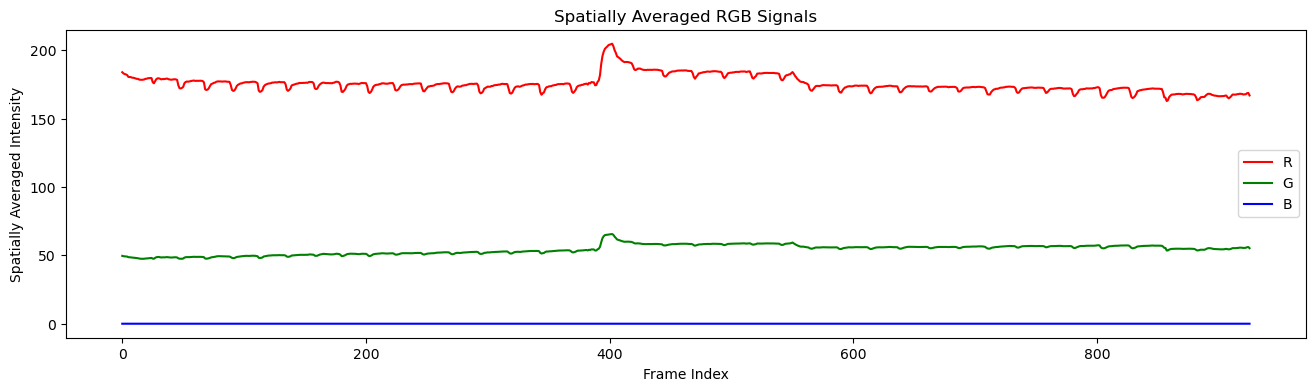

In [48]:
fig = plt.figure(figsize=(16, 4))
plt.plot(xr, color="r", label="R")
plt.plot(xg, color="g", label="G")
plt.plot(xb, color="b", label="B")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("Spatially Averaged Intensity")
plt.title("Spatially Averaged RGB Signals")
plt.show()
fig.savefig("unnormalized_spatialavgs.png", dpi=300)

There's two important features of this plot that are worth explaining:
1. These signals mostly jump up and down - this corresponds to the heart actually beating! Note that this is (more or less) periodic, as your resting heart rate should be fairly consistent over a small period of time (30 seconds here).
2. There's a huge jump in the middle. This is because the person taking the video moved their thumb during the recording. Ideally, we'd retake the data, but it's good to be aware of these kinds of issues, as they often arise when correcting real world data.

## Q1b: Statistical Normalization

As is, your plot from the previous part may be a bit confusing. Why is the R component so much stronger than the G component, and, likewise, why does G dominate B? Why do R and G seem to be offset from each other? The issue is that our signals aren't *normalized* - since our skin, up close, is mostly red, the R component dominates the others. While it would be very convenient to conclude that the red signal must correspond to the blood, so we should just throw out the others and only use it since it's the strongest, the authors in [2] showed that such a simple model is not very robust. 

What works much better, it turns out, is to model the RGB channels as mixtures of different "source signals", one of which is the person's bloodstream (the others being noise sources, such as changes in ambient lighting or the person moving their thumb during the recording) and "unmixing" them to recover the original signals. Before doing so, we'll need to normalize the signals in a statistical sense, making them zero mean and unit variance. The reason for doing so is that our unmixing algorithm, which we'll go through in Q2, heavily relies on the signals' statistical properties, and applying this normalization gives better results. Think of it this way - which bowl's ingredients would you rather try to separate: one created by mixing equal parts baking soda, sugar, and flour, or one obtained from 90% baking soda, 9% sugar, and 1% flour? 

In the cell below, perform the statistical normalization. Again, this should be a one liner (per signal). To make a signal $x(t)$ zero mean and unit variance, you can first subtract its mean ($\mu_x$), then divide by its standard deviation ($\sigma_x$), each of which is taken across all samples to return a real number:

$$x_\text{normalized}(t) = \dfrac{x(t) - \mu_x}{\sigma_x}$$

**Hint:** Check out the functions [`np.mean`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) and [`np.std`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html).

In [49]:
# TODO your normalization code here
xr_normalized = (xr - np.mean(xr)) / np.std(xr)
xg_normalized = (xg - np.mean(xg)) / np.std(xg)
xb_normalized = (xb - np.mean(xb)) / np.std(xb)

Now, run the cell below to plot the spatially averaged signals. Again, plotting code has been provided for you. 

If your code's correct, the plot should look like this:

<img src="./normalized_avgs.png" alt="drawing" style="width:800px; height=1200px"/>

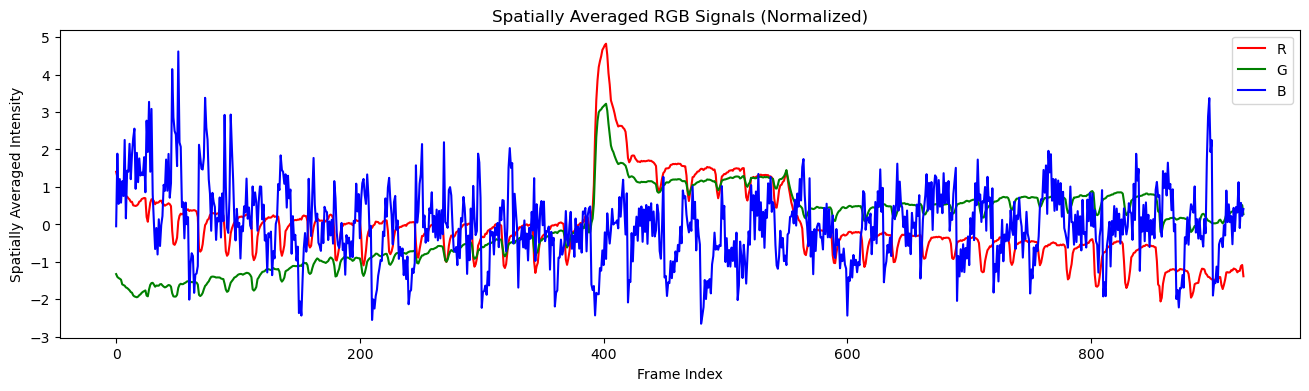

In [50]:
plt.figure(figsize=(16, 4))
plt.plot(xr_normalized, color="r", label="R")
plt.plot(xg_normalized, color="g", label="G")
plt.plot(xb_normalized, color="b", label="B")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("Spatially Averaged Intensity")
plt.title("Spatially Averaged RGB Signals (Normalized)")
plt.show()

## Q1c: Blind Source Separation

Before we try to extract heart rate information from our signals, there's one more thing we need to do. As mentioned above, all the research on non-contact heart rate monitoring using the approach we're implementing here says that robustness is improved by modelling the RGB channels as being generated by mixtures of different *source signals*. In [2], the authors note that this model is popular in several medical applications for noise removal, including electrocardiograms, which are used in hospitals for heart rate monitoring.

### Modelling signal mixtures

The issue is that we don't know what the source signals are, or even what kind of process generated our RGB signals from them - how are we supposed to recover them? This problem, known as *Blind Source Separation (BSS)* - the "Blind" coming from the fact that we don't know the true source signals - is indeed a challenging one. As is typically done in engineering when a problem seems too difficult because it's too general, we'll make some simplifying assumptions. Specifically, we'll assume:
- A linear relationship between the source signals and our RGB signals (so the RGB signals are linear combinations of the sources). While this may not be entirely true, it greatly simplifies the problem and, at the very least, gives us a first-order approximation.
- The sources are independent of each other. There are statistical reasons for this assumption which you can read more about in the references.
- **The number of sources equals the number of signals - 3 here, one for each RGB channel.** The rationale for this assumption is rooted in what you learned in EE 16AB. Assume we have $S$ source signals, and $M$ measured signals (here, $M = 3$ - one per color channel).
    - If $M < S$, we have *less* measurements than linear equations to solve, yielding an *underdetermined* linear system. Typically, underdetermined systems have infinitely many solutions.
    - If $M > S$, we have *more* measurements than linear equations to solve, yielding an *overdetermined* linear system, which often has no solutions. You saw in EE 16A that the method of least squares can be used in this case for picking the "best" solution from the infinity of options (by picking the solution that minimizes the sum of squared errors). However, least squares requires knowledge of both the outputs (the RGB signals, which we do have) and the outputs (the source signals, which we don't have) and gives you the optimal combination coefficients. Essentially, least squares can only handle the weights being unknown; here, both the weights AND the source signals are unknown! This is what makes "blind" source separation so difficult. 
    - If $M = S$, we have exactly as many measurements as linear equations to solve. These systems typically have a single, unique solution, making them the easiest to deal with.
    
Note: For those of you with a machine learning background, $S$, the number of source signals, would in general be a hyperparameter tuned using validation. Here, we're fixing it at 3, the number of measured signals, because it: 
- Leads to a more numerically tractable problem.
- Avoids extra complications in implementing this system.
- Still works reasonably well.

### Independent Component Analysis

Fortunately, there are many methods for solving this problem, and we'll use the same one [1, 2] did: *Independent Component Analysis (ICA)*. Here's a nice visual taken from [2] showing ICA as a block diagram. In [2], monitoring was done in real time on recordings of faces, with heart rate information extracted from the cheeks, hence why the left hand side of the diagram starts with a person's face. This tends to produce much cleaner data than thumb recordings, which we used here for simplicity, but avoids spending 80% of the lab on computer vision techniques just to pick out the relevant area before we get to do any signals and systems.

<img src="ICAvisual.png" alt="Drawing" style="width: 50em;"/>

The internals of how ICA algorithms work are far beyond the scope of this class, drawing on ideas presented in EECS 126, EECS 127, and EE 229A. You can check out the references given at the end of the lab if you're interested in the details. For our purposes, however, it's fine to think of ICA as a black box that takes in our "mixed" signals, does the unmixing, and gives us back the sources.

### Your Job

While we will typically make you implement algorithms on your own in the labs so you can better understand them, it's also good to know how to research what library implementations exist. Unless you've just invented the algorithm yourself, it almost certainly exists in numpy, scipy, or one of the many other open source scientific computing libraries written for Python. And, in just about every case, the implementation there will be at least 10x more efficient than anything you could create in a reasonable amount of time. Not to mention, library functions have (typically) been extensively tested and debugged.

Check out the documentation for [sklearn's implementation of ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html), and use it to perform BSS on your normalized signals. We already imported `FastICA` earlier. **Store the result in a matrix called `sources`**.

**Hint:** The function will expect your signals input as a single *data matrix*, where each column is a separate signal. First, construct this matrix to pass into the function. A good sanity check is that `np.shape()` of your input matrix is `(926, 3)` since we have 926 frames (or, after our 1D-ificiation of the videos, 926 signal values) and 3 signals.

In [51]:
# TODO create data matrix
raw_sources = np.vstack((xr_normalized, xg_normalized, xb_normalized)).T
np.shape(raw_sources)

(926, 3)

In [52]:
# TODO your ICA code here
transformer = FastICA(n_components=3, whiten="unit-variance")
sources = transformer.fit_transform(raw_sources)

Once done, run the plotting code below to see the extracted sources! 

If your ICA code is correct, your results may look like this:

<img src="./source_sigs1.png" alt="drawing" style="width:800px; height=1200px"/>

**However, ICA is implemented under the hood using a randomized algorithm that can converge to different results each time you run it**, so you may also get something that looks like this:

<img src="./source_sigs2.png" alt="drawing" style="width:800px; height=1200px"/>

Or even like this:

<img src="./source_sigs3.png" alt="drawing" style="width:800px; height=1200px">

Fortunately, the differences won't really affect our ability to correctly extract the heart rate. We're going to be looking at the frequencies that make up each signal to figure this out, which isn't affected much by vertical offsets or rescalings which account for most of the differences between these plots. Recall that rescaling a signal by a constant doesn't filter out any frequencies; everything will just be scaled by that constant since the Fourier Transform is linear. Understanding these properties helps us sanity check things, which is why they're worth learning :)

If you're really concerned, re-run your ICA code a few times until you get something that looks like either of these two plots.

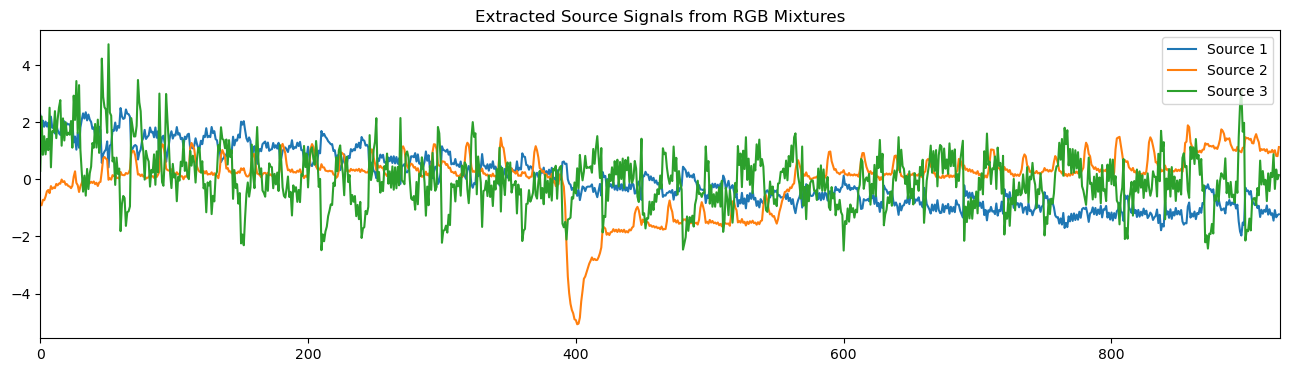

In [53]:
fig = plt.figure(figsize=(16, 4))
plt.plot(sources[:, 0], label="Source 1")
plt.plot(sources[:, 1], label="Source 2")
plt.plot(sources[:, 2], label="Source 3")
plt.legend(loc="upper right")
plt.title("Extracted Source Signals from RGB Mixtures")
plt.xlim([0, len(sources[:, 0])])
plt.show()
fig.savefig("source_sigs3.png", dpi=300)

# Q2: Frequency Analysis via the Power Spectrum

We did a lot in the previous question, going all the way from a raw video recording to extracting source signals for analysis. Believe it or not, we're almost done building our heart rate monitor! The only thing we have left to do is figure out the heart rate from these signals. 

## The Power Spectrum of a Signal

The source signals we extracted in Q1c don't look promising as displayed. We saw in Lab 3 that we can use the FFT to efficiently compute the DFT, which gives us samples of a signal's DTFT. This allows us to understand the strengths of the oscillations that make up the signal, so to speak. In the case of our data, this interpretation is very natural - our signal has fluctuations up and down corresponding to the person's heart beating, so the signal's *dominant frequency* (the frequency at which the magnitude of the signal's DTFT is maximized) is precisely the frequency at which their heart is beating! Recall that the DTFT is complex-valued, meaning it contains information about both magnitude and phase. Intuitively, magnitude corresponds to the "strength" of the frequency whereas phase enocdes information about where the frequency is present in the signal. Since we assume an approximately constant heart rate throughout the recording, we only care about the strengths of the frequencies, not where they show up in the signal.

We'll use this idea of finding the dominant frequency to compute the person's estimated heart rate. More specifically, we want the *power spectra* of the signals, defined as the square of the signals' Fourier Transform magnitudes. 

**That is, if $x[n]$ has DTFT $X(\omega)$, its power spectrum is defined as $|X(\omega)|^2$.**

Interestingly, the power spectrum of a signal $x[n]$ corresponds to the DTFT of the autocorrelation of $x[n]$. We could also use the magnitude response $|X(\omega)|$, without any squaring, and still get the same results (since squaring something doesn't affect where its maxima are) but then the spectral peaks (i.e. the local maxima of $|X(\omega)|$) aren't as easy to visually resolve, and it's often useful to visualize things, *especially* when debugging.

## Q2a: Computing the Power Spectrum

In the cell below, compute the power spectrum of each of the three source signals. Store the result in a variable called `PS`.

**Hint 1:** You should do this all in one line on the ICA-returned data matrix `sources` by using the `axis` parameter of `np.fft.fft`. As for the absolute value and squaring, remember, numpy is built for vectorization - if you call a scalar function (one that maps a number to a number) on a numpy array of any number of dimensions (here, 2, since we have a matrix), numpy will apply it elementwise for you.

**Hint 2:** We adopted the convention above of each column of our data matrix being a separate signal - keep this in mind when figuring out what to pass in for `axis`. A great way to check if you've done this correctly is that `np.shape(PS)` should be the same as `np.shape(sources)`.

In [54]:
# TODO your power spectrum code here
PS = abs(np.fft.fft(sources, axis=0))
PS *= PS

Now, let's plot the signals' power spectra. We've provided the plotting code for you, and there's three things worth commenting on:
- **Frequency shifting**. By default, `np.fft.fft` returns the DTFT samples (i.e., DFT coefficients) arranged from $0$ to $2\pi$. We call `np.fft.fftshift` here, which circularly shifts the result so that the frequencies are from $-\pi$ to $\pi$. This is typical in practice, as the symmetry about $\omega = 0$ in magnitude responses creates a nicer plot.
- **Interpreting the frequencies**. The data we have here (the video) was obtained by a cell phone camera taking pictures at 30 frames per second. This means we get one new sample of data (i.e., an image of the thumb) 30 times each second. As a result, we say that our *sampling frequency* is 30 Hz for this data. Alternatively, the data was *sampled at 30 Hz*. We haven't covered sampling in detail yet. Fortunately, there's only one result relevant to our analysis here: the Shannon-Nyquist Sampling Theorem. Briefly speaking, it says that if you take samples of a signal at $f$ Hz, the highest frequency you will observe corresponds to $f / 2$ Hz. The implication of this when taking the FFT of our data (again, this is just a sampling of the DTFT) is that the x-axis, which implicitly goes from $-\pi$ to $\pi$ (any interval of length $2\pi$ will do since the DTFT is $2\pi$-periodic, but this is the most popular choice, as discussed in the previous point), phyiscally corresponds to going from -15 Hz to 15 Hz (since the highest frequency is $\pi$ in discrete-time, and the highest frequency we can make out is 15 Hz). As a result, when plotting the FFT, it's useful to use x-axis labels ranging from -15 to 15.
- **Meta-information**. Realistically, a person's heart rate won't be below 45 bpm (.75 Hz) or above 240 bpm (4 Hz), so it doesn't make sense to look at any frequencies outside of this range; they're just noise. Often, knowledge about the system or task at hand itself, called *meta-information*, helps inform engineers when designing algorithms, and that's exactly the case here. 

Since the second point hinges on content we haven't covered yet, the code's been provided for you.

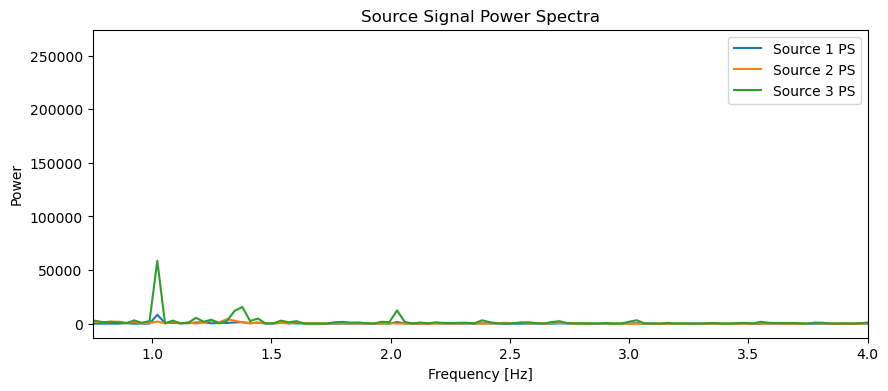

In [55]:
# Plot power spectra
PS_shifted = np.fft.fftshift(PS, axes=0)  # shift to -pi to pi
frame_rate = 30
freqs = np.linspace(-frame_rate / 2, frame_rate / 2, len(PS))  # -15 Hz to 15 Hz range
plt.figure(figsize=(10, 4))
plt.plot(freqs, PS_shifted[:, 0], label="Source 1 PS")
plt.plot(freqs, PS_shifted[:, 1], label="Source 2 PS")
plt.plot(freqs, PS_shifted[:, 2], label="Source 3 PS")
plt.title("Source Signal Power Spectra")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.legend(loc="upper right")
plt.xlim([0.75, 4])  # limit viewing range to realistic frequencies
plt.show()

One of the sources will be noticeably stronger than the other two, and if your power spectrum code is correct, you should see three distinct peaks in it: one just after 1.0 Hz, one around 1.4 Hz, and one just after 2.0 Hz. The one near 1.0 Hz should be the strongest.

In order to make our lives easier in the next part, we can collapse the three power spectra down into one by only keeping the largest value at each point in time. Intuitively, the largest peaks should correspond to information about the heart beat, so we only care about the largest one detected at each point in time.

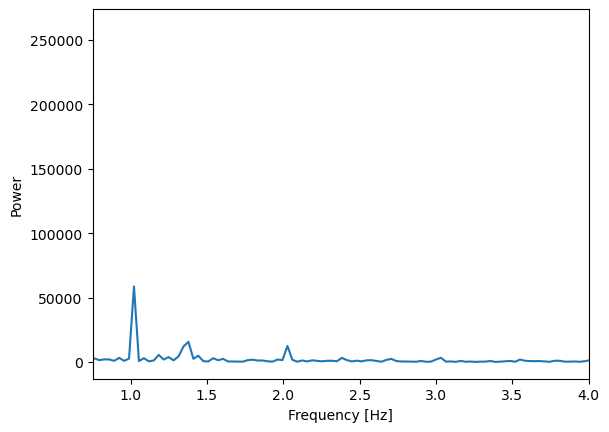

In [58]:
max_ps = np.max(PS_shifted, axis=1)
plt.plot(freqs, max_ps)
plt.xlim([0.75, 4])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()

From here on, we'll only deal with `max_ps` rather than the 3 separate power spectra.

## Q2b: Extracting the Dominant Frequency

That strongest peak, which occurs at the dominant frequency, is from the person's heart beat! We just need to write some code to extract that frequency, multiply it by 60 (since we want beats per minute, not beats per second), and we'll have computed the person's heart rate! First, let's define some useful constants.

In [59]:
SEC_PER_MIN = 60
MIN_BPM = 45
MAX_BPM = 240

Now, in the cell below, extract the dominant frequency $f_{d}$, and then compute the heart rate from it by:
- Computing the indices of `freqs` (which was defined for you above) that are between 60 bpm and 240 bpm. Check out [np.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) and [np.bitwise_and](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bitwise_and.html) for doing this.
- Cropping both `freqs` and `max_ps` to this range.
- Extracting $f_{d}$ from the cropped frequencies as the element at the index where your cropped power spectrum is maximized. Check out [np.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) for this.
- Computing the heart rate from $f_d$ by scaling it by `SEC_PER_MIN`. **Store it in a variable called `hr`.**

In [62]:
# TODO your code here!
mask = (freqs >= MIN_BPM / SEC_PER_MIN) & (freqs <= MAX_BPM / SEC_PER_MIN)
freqs = freqs[mask]
max_ps = max_ps[mask]
fd = freqs[np.argmax(max_ps)]
hr = fd * SEC_PER_MIN  # store end result here

Once done with the above, run the cell below to see what heart rate you end up getting. For reference, the person's actual heart rate was measured by an independent monitor to vary between 58-63 bpm. See how your result compares!

In [63]:
print("Heart Rate: {0} bpm".format(round(hr, 1)))

Heart Rate: 61.3 bpm


# Q3: Testing on More Data

Now that we've done all the work of implementing the heart rate detection algorithm, let's test it on some real data! We took several videos and converted them to `.npy` files for you; run the next cell to load them. The first is the same one we used throughout Q1 and Q2 above. 

This cell will take a while to run: the `.npy` files are uncompressed, and range from 500 MB to upward of 6 GB in size.

In [64]:
data1 = np.load("data1.npy")
data2 = np.load("data2.npy")
data3 = np.load("data3.npy")
data4 = np.load("data4.npy")

Now, fill in the function below based on all the previous parts so that we can, with a single function call, output a heart rate given a raw video file. You shouldn't have to write any new code.

In [70]:
def meas_hr(raw_data, min_bpm=45, max_bpm=240, frame_rate=30):
    """
    Given a video recording of a person's thumb (raw_data), returns their average heart rate
    for the duration of the recording.
    """
    SEC_PER_MIN = 60

    # TODO -> (Q1 intro) Extract components
    xr_video = raw_data[:, :, :, 0]
    xg_video = raw_data[:, :, :, 1]
    xb_video = raw_data[:, :, :, 2]
    # TODO -> (Q1a) Averaging
    xr = np.mean(xr_video, axis=(1, 2))
    xg = np.mean(xg_video, axis=(1, 2))
    xb = np.mean(xb_video, axis=(1, 2))
    # TODO -> (Q1b) Normalize
    xr_normalized = (xr - np.mean(xr)) / np.std(xr)
    xg_normalized = (xg - np.mean(xg)) / np.std(xg)
    xb_normalized = (xb - np.mean(xb)) / np.std(xb)
    # TODO -> (Q1c) Create data matrix
    raw_sources = np.vstack((xr_normalized, xg_normalized, xb_normalized)).T
    np.shape(raw_sources)
    # TODO -> (Q1c) ICA to get sources matrix
    transformer = FastICA(n_components=3, whiten="unit-variance")
    sources = transformer.fit_transform(raw_sources)
    # TODO -> (Q2a) Compute power spectra
    PS = abs(np.fft.fft(sources, axis=0))
    PS *= PS
    PS_shifted = np.fft.fftshift(PS, axes=0)  # shift to -pi to pi
    frame_rate = 30
    freqs = np.linspace(-frame_rate / 2, frame_rate / 2, len(PS))  # -15 Hz to 15 Hz range
    max_ps = np.max(PS_shifted, axis=1)
    # TODO -> (Q2b) Extracting dominant frequency and convert to heart rate
    mask = (freqs >= min_bpm / SEC_PER_MIN) & (freqs <= max_bpm / SEC_PER_MIN)
    freqs = freqs[mask]
    max_ps = max_ps[mask]
    fd = freqs[np.argmax(max_ps)]
    hr = fd * SEC_PER_MIN
    return hr

Once done, run the cells below to try out your heart rate monitor! For reference, here are the true heart rates the people had in each dataset.
- Dataset 1: 58-63 bpm. (resting)
- Dataset 2: 66-71 bpm. (resting)
- Dataset 3: 76-82 bpm. (walking)
- Dataset 4: 68-70 bpm. (resting)

Don't worry if you get incorrect results on a few of these - this happens when dealing with real world data! You saw in Q2a that it's possible for multiple peaks to appear. We found that when the algorithm does give an incorrect result, it's typically not because the peak corresponding to the heart rate doesn't exist, but rather that there's some other peak (likely caused by a combination of noise sources) that's stronger. By far the biggest source of errors (once your code is working) will be noisy data - holding your thumb up to a cell phone camera doesn't exactly produce the highest quality recording. Feel free to play with the lower and upper thresholds (`min_bpm` and `max_bpm`) and seeing how your results change as you eliminate more possibilities! 

From a grading perspective, we only care that you're able to synthesize the previous parts we built up into one function - everything below here is for you to play around with.

In [66]:
def disp_hr(hr, dataset):
    print("Average Heart Rate (dataset {0}): {1} bpm".format(dataset, round(hr, 1)))

In [71]:
disp_hr(meas_hr(data1), 1)
disp_hr(meas_hr(data2), 2)
disp_hr(meas_hr(data3), 3)
disp_hr(meas_hr(data4), 4)

Average Heart Rate (dataset 1): 61.3 bpm
Average Heart Rate (dataset 2): 48.8 bpm
Average Heart Rate (dataset 3): 78.8 bpm
Average Heart Rate (dataset 4): 69.3 bpm


In [72]:
# What if we put the lower limit at 50 for the 2nd dataset? Will the result be made correct?
disp_hr(meas_hr(data2, min_bpm=50), 2)

Average Heart Rate (dataset 2): 69.6 bpm


# Further ways to improve our heart rate monitor

We managed to take an approach developed by other researchers, implement it ourselves, and get some pretty cool results! While we did indeed follow the *method* described in [1, 2] for heart rate monitoring (aside from how we acquired our data), there are a few things that could be improved about our specific *implementation* of it:
- **Computational Efficiency.** We only vectorized our code from the ICA portion on. To make the code faster, we would create our data matrix right from the start, with one channel in each column as we did later.
- **Temporal Resolution.** Our monitor computes an average heart rate based on the data we feed it. A common task of interest for professional sports teams is to monitor their players' heart rates during various exercises. Since we only compute a single average, we lose all information about how the heart rate changes with time (if the person's heart rate is constant, we don't lose anything, but there are plenty of scenarios where this won't be the case). To combat this, we could slide a moving window over our data, computing the heart rate over a 30 second window, then advance by 1 second, recompute, and so on, so we get a new estimate for every second. This was what the authors ended up doing in [2].

We encourage you to try these out on your own, in addition to taking data of your own thumb (or even other sources, like other fingers or your cheeks), although you're not required to implement any of them here. In [1,2] the authors used peoples' faces and applied computer vision techniques to select a *Region of Interest* (ROI) to use for heart rate detection; these techniques are beyond the scope of this class (see EE 225B and CS 280 for more detailed treatments of 2D and 3D signal processing techniques) so we've considered a simplified version here by using the thumb, albeit at a sacrifice to the quality of our data. 

# References

[1] *Measuring Heart Rate from Video*. [Link](https://web.stanford.edu/class/cs231a/prev_projects_2016/finalReport.pdf).  
[2] *Non-contact, automated cardiac pulse measurements using video imaging and blind source separation.*
[Link](https://www.osapublishing.org/DirectPDFAccess/3C66D9B3-E3ED-58AA-DF056147993BD0BD_199381/oe-18-10-10762.pdf?da=1&id=199381&seq=0&mobile=no).   
[3] *Camera-based Heart Rate Monitoring*. [Link](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6796/pdf/imm6796.pdf).    
[4] Wikipedia page on ICA. [Link](https://en.wikipedia.org/wiki/Independent_component_analysis).  
[5] *Independent component analysis, A new concept?* [Link](http://mlsp.cs.cmu.edu/courses/fall2012/lectures/ICA.pdf). The original paper on ICA - it has over 10000 citations!!!   
[6] *Independent component analysis.* [Link](https://www.cs.helsinki.fi/u/ahyvarin/papers/bookfinal_ICA.pdf). An entire textbook on ICA.  
[7] *A Tutorial on Independent Component Analysis.* [Link](https://arxiv.org/pdf/1404.2986.pdf). A *tutorial paper* is a publication aimed at explaining a concept rather than presenting original research.